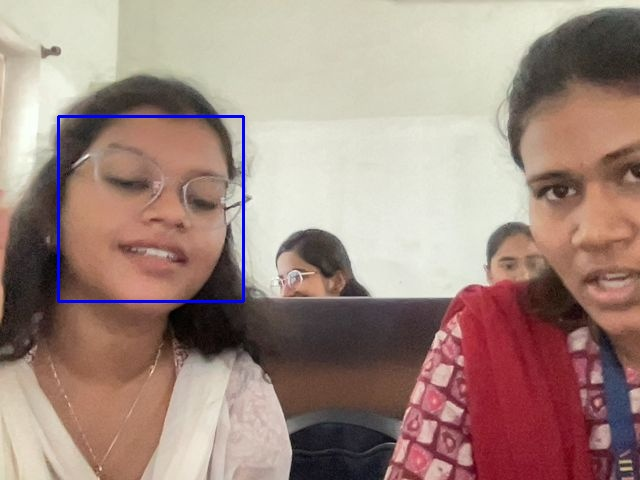

In [5]:
# Install OpenCV
!pip install opencv-python

import cv2
import numpy as np
from google.colab import output
from base64 import b64decode, b64encode
from io import BytesIO
from PIL import Image
import IPython.display as display

# Load Haar cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Function to process an image and detect faces
def detect_faces_live(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
    return img

# JS to capture webcam photo
def take_photo():
    js = """
    async function takePhoto() {
        const div = document.createElement('div');
        const video = document.createElement('video');
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        video.play();

        await new Promise(resolve => setTimeout(resolve, 2000)); // Wait for camera

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getTracks().forEach(track => track.stop());
        div.remove();

        return canvas.toDataURL('image/jpeg', 0.8);
    }
    takePhoto().then(data => {
        google.colab.kernel.invokeFunction('notebook.ReceiveImage', [data], {});
    });
    """
    output.eval_js(js)

# Function to receive and process image from JS
def receive_image(data):
    header, encoded = data.split(",", 1)
    img_data = b64decode(encoded)
    img = Image.open(BytesIO(img_data))
    img_np = np.array(img)
    img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

    # Detect faces
    result_img = detect_faces_live(img_bgr)

    # Display result
    _, buffer = cv2.imencode('.jpg', result_img)
    display.display(Image.open(BytesIO(buffer.tobytes())))

# Register callback
output.register_callback('notebook.ReceiveImage', receive_image)

# Capture and detect
take_photo()
